# Прогнозирование стоимости автомобилей Ford по VIN-коду

Нам предоставлены данные по автомобилям `Ford`, произведённым в Северной Америке, содержащие информацию о их VIN-кодах и стоимости.  

__Цель__: с помощью регулярных выражений распарсить VIN-коды и построить модель, предсказывающую стоимость автомобилей на основании полученных данных

Нам известно, что VIN-код состоит из 17 символов (последние три знака – всегда цифры), включающих заглавные буквы латинского алфавита (за исключением __I__, __O__, __Q__) и цифры от 0 до 9, где:
- 1-3 - производитель;
- 4 - ремни безопасности для пассажирских, тормоза и грузоподъёмность у траков;
- 5-7 - модель;
- 8 - двигатель;
- 9 - контрольный знак;
- 10 - год (в кодировке года не используются буквы __U__ и __Z__ );
- 11 - завод-производитель;
- 12-17 - серийный номер

<h1>Этапы исследования:<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1">Загрузка данных</a></span></li><li><span><a href="#Предобработка" data-toc-modified-id="Предобработка-2">Предобработка</a></span></li><li><span><a href="#Построение-моделей" data-toc-modified-id="Построение-моделей-3">Построение моделей</a></span><ul class="toc-item"><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.1">RandomForestRegressor</a></span><ul class="toc-item"><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3.1.1">Обучение</a></span></li><li><span><a href="#Анализ-важности-фичей" data-toc-modified-id="Анализ-важности-фичей-3.1.2">Анализ важности фичей</a></span></li></ul></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.2">LGBMRegressor</a></span><ul class="toc-item"><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3.2.1">Обучение</a></span></li><li><span><a href="#Анализ-важности-фичей" data-toc-modified-id="Анализ-важности-фичей-3.2.2">Анализ важности фичей</a></span></li></ul></li><li><span><a href="#DummyRegressor" data-toc-modified-id="DummyRegressor-3.3">DummyRegressor</a></span></li></ul></li><li><span><a href="#Проверка-лучшей-модели-на-тесте" data-toc-modified-id="Проверка-лучшей-модели-на-тесте-4">Проверка лучшей модели на тесте</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5">Вывод</a></span></li></ul></div>

## Загрузка данных

In [1]:
#pip install phik

In [2]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import (
    RandomizedSearchCV,
    train_test_split
)
from lightgbm import LGBMRegressor
from sklearn.preprocessing import OrdinalEncoder
from phik.report import plot_correlation_matrix
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_percentage_error
)

RANDOM_STATE = 12345
sns.set_style('darkgrid')

In [3]:
with open('car.txt', 'r', encoding='utf-8') as file:
    contents = file.read()

In [4]:
contents[:245]

'[2FMDK3JC4BBA41556:12500]мой[3FA6P0H75ER208976:14500]дядя [3FAHP08Z17R268380:1300][1FMCU0GX3DUC59421:15200]самых [1FAHP2E89DG119368:11600] верных[1FM5K8D82DGA16143:26400][1FTFW1CFXCFC23663:14000][2FMDK3JC6CBA90002:19500][1FTFW1CT8DKD06233:24400]'

In [5]:
valid_letter = [chr(x) for x in range(ord('A'), ord('Z')+1) if chr(x) not in ['I', 'O', 'Q']]
valid_letter

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'J',
 'K',
 'L',
 'M',
 'N',
 'P',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z']

In [6]:
num = [r'\d']
num

['\\d']

In [7]:
valid_chars = ''.join(valid_letter + num)
valid_chars

'ABCDEFGHJKLMNPRSTUVWXYZ\\d'

In [8]:
wmi = f'(?P<wmi>[{valid_chars}]{{3}})' # 1-3
brake = f'(?P<brake>[{valid_chars}])' # 4
model = f'(?P<model>[{valid_chars}]{{3}})' # 5-7
engine = f'(?P<engine>[{valid_chars}])' # 8
check = f'(?P<check>[{valid_chars}])' # 9
year = f'(?P<year>[{valid_chars.replace("U", "").replace("Z", "")}])' # 10
plant = f'(?P<plant>[{valid_chars}])' # 11
vis = f'(?P<vis>[{valid_chars}]{{3}}\\d{{3}})' # 12-17
price = f':(?P<price>\d+)' # цена

In [9]:
vin_full_and_price = f'\\b{wmi}{brake}{model}{engine}{check}{year}{plant}{vis}{price}\\b'
vin_re = re.compile(vin_full_and_price)
data = pd.DataFrame([x.groupdict() for x in vin_re.finditer(contents)])

In [10]:
data.head()

,wmi,brake,model,engine,check,year,plant,vis,price
0,2FM,D,K3J,C,4,B,B,A41556,12500
1,3FA,6,P0H,7,5,E,R,208976,14500
2,3FA,H,P08,Z,1,7,R,268380,1300
3,1FM,C,U0G,X,3,D,U,C59421,15200
4,1FA,H,P2E,8,9,D,G,119368,11600


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71884 entries, 0 to 71883
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   wmi     71884 non-null  object
 1   brake   71884 non-null  object
 2   model   71884 non-null  object
 3   engine  71884 non-null  object
 4   check   71884 non-null  object
 5   year    71884 non-null  object
 6   plant   71884 non-null  object
 7   vis     71884 non-null  object
 8   price   71884 non-null  object
dtypes: object(9)
memory usage: 4.9+ MB


Датасет содержит 71884 строки и 9 столбцов. Пропуски отсутствуют. Численный целевой признак имеет некорректный тип данных object

## Предобработка

Преобразуем тип данных таргета object в целочисленные значения

In [12]:
data['price'] = data['price'].astype('int')

Выведем описательную статистику

In [13]:
data.describe(include='all').round(2).fillna('-')

,wmi,brake,model,engine,check,year,plant,vis,price
count,71884,71884,71884,71884,71884,71884,71884,71884,71884.0
unique,14,26,365,32,11,25,21,68215,-
top,1FM,D,P0H,2,1,D,R,B55197,-
freq,18347,12370,6171,7015,6622,17286,10535,4,-
mean,-,-,-,-,-,-,-,-,14321.45
std,-,-,-,-,-,-,-,-,7827.06
min,-,-,-,-,-,-,-,-,1000.0
25%,-,-,-,-,-,-,-,-,8800.0
50%,-,-,-,-,-,-,-,-,13500.0
75%,-,-,-,-,-,-,-,-,19500.0


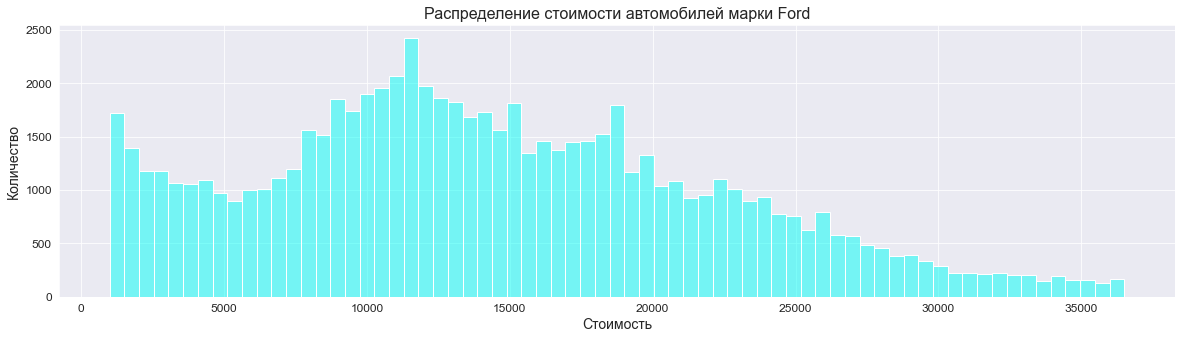

In [14]:
plt.figure(figsize=(20,5))
sns.histplot(data, palette='hsv', legend=False)
plt.title('Распределение стоимости автомобилей марки Ford', fontsize=16)
plt.xlabel('Стоимость', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

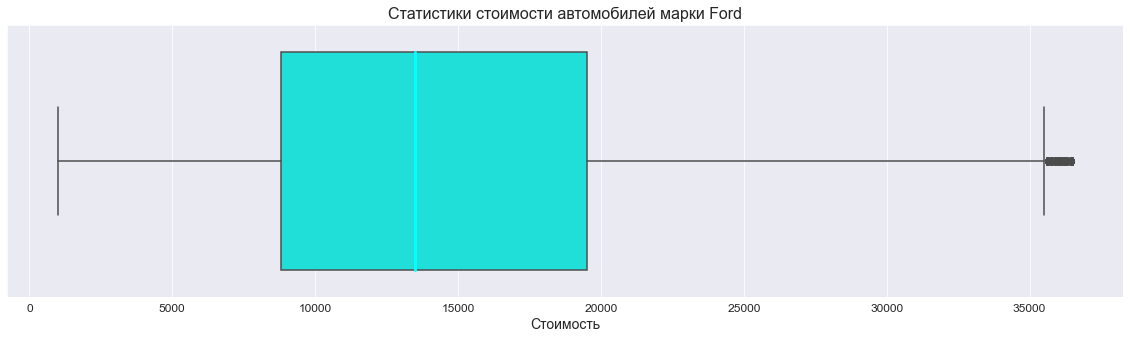

In [15]:
plt.figure(figsize=(20,5))
sns.boxplot(x=data['price'], palette='hsv', medianprops={'color': 'cyan', 'linewidth':3})
plt.title('Статистики стоимости автомобилей марки Ford', fontsize=16)
plt.xlabel('Стоимость', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

Проверим датасет на наличие явных дубликатов

In [16]:
data.duplicated().sum()

0

Удалим неинформативный столбец vis с серийный номер и посмотрим на корреляцию оставшихся признаков

In [17]:
data.drop('vis', axis=1, inplace=True)

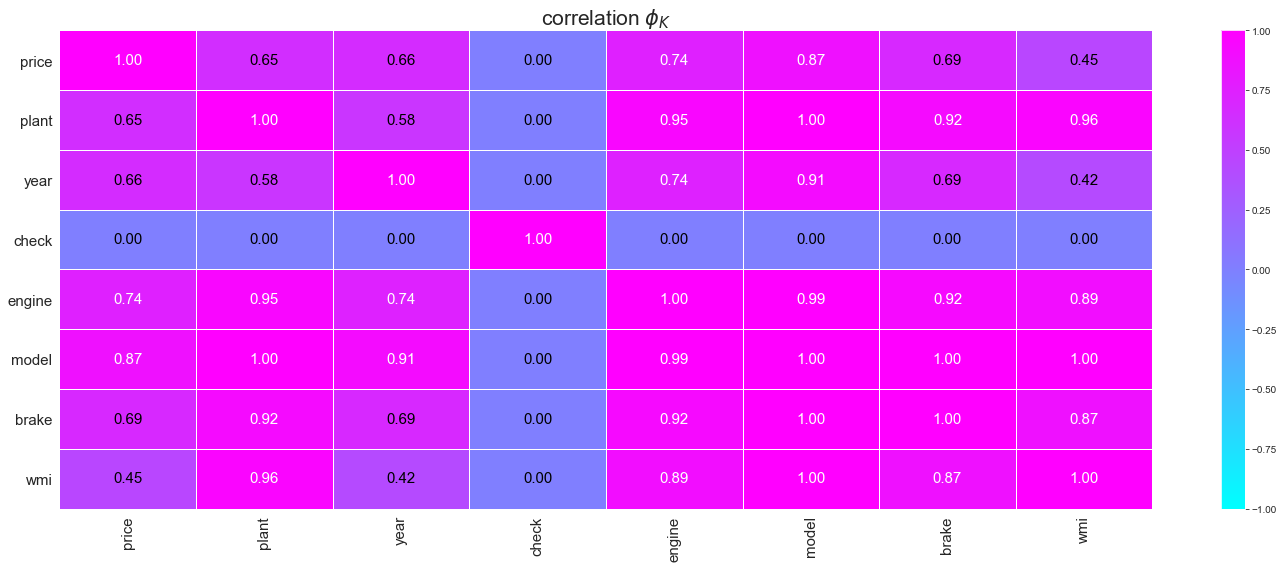

In [18]:
phik_overview = data.phik_matrix(interval_cols=['price'])
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index,
                        title=r'correlation $\phi_K$', figsize=(20,8), fontsize_factor=1.5, color_map='cool')

Удалим неинформативный столбец check - контрольный, который согласно матрице имеет нулевую корреляцию с таргетом

In [19]:
data.drop('check', axis=1, inplace=True)

Поскольку не предполагаем использовать линейные модели, нет необходимости в избавлении от мультиколлинеарных признаков

## Построение моделей

In [20]:
features = data.drop('price', axis=1)
target = data.price

In [21]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)

In [22]:
# Выведем размеры обучающей и тестовой выборок

print(f'Размер обучающей выборки: признаки - {features_train.shape}, целевая переменная - {target_train.shape[0]}')
print(f'Размер тестовой выборки: признаки - {features_test.shape}, целевая переменная - {target_test.shape[0]}')

Размер обучающей выборки: признаки - (53913, 6), целевая переменная - 53913
Размер тестовой выборки: признаки - (17971, 6), целевая переменная - 17971


### RandomForestRegressor

#### Обучение

Используем пайплайн с целью избежания утечки данных и RandomizedSearchCV для быстрого подбора гиперпараметров при помощи кросс-валидации.
Для моделей на основе деревьев решений можно использовать порядковое кодирование категориальных переменных. Это поможет сократить время обучения и подбора параметров модели без явной потери качества.

In [23]:
pipe = Pipeline([
    ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ('rfr', RandomForestRegressor(random_state=RANDOM_STATE))
])

param_random_rfr = {
    'rfr__bootstrap': [True, False],
    'rfr__n_estimators': range(10, 101, 10),
    'rfr__max_depth': range(2, 15),
    'rfr__min_samples_split': (2, 3, 4),
    'rfr__min_samples_leaf': (1, 2, 3, 4)
}

rs_rfr = RandomizedSearchCV(
    pipe,
    param_distributions=param_random_rfr, 
    scoring={'RMSE': 'neg_root_mean_squared_error', 'MAPE': 'neg_mean_absolute_percentage_error', 
             'MSE': 'neg_mean_squared_error'},
    refit='RMSE',  
    cv=5,
    n_iter=25,
    n_jobs=-1
)

In [24]:
%%time
rs_rfr.fit(features_train, target_train)
print('Метрика RMSE:', abs(rs_rfr.best_score_).round(2))
print('Метрика MSE:', abs(rs_rfr.cv_results_['mean_test_MSE']).mean().round(2))
print('Метрика MAPE:', abs(rs_rfr.cv_results_['mean_test_MAPE']).mean().round(2))
print('Лучшие параметры:', rs_rfr.best_params_)

Метрика RMSE: 2800.35
Метрика MSE: 15143990.64
Метрика MAPE: 0.31
Лучшие параметры: {'rfr__n_estimators': 50, 'rfr__min_samples_split': 4, 'rfr__min_samples_leaf': 4, 'rfr__max_depth': 14, 'rfr__bootstrap': True}
CPU times: total: 8.64 s
Wall time: 1min 4s


#### Анализ важности фичей

In [25]:
feature_names = features.columns
result = permutation_importance(
    rs_rfr, features_train, target_train, n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1
)
forest_importances = pd.Series(result.importances_mean, index=feature_names)

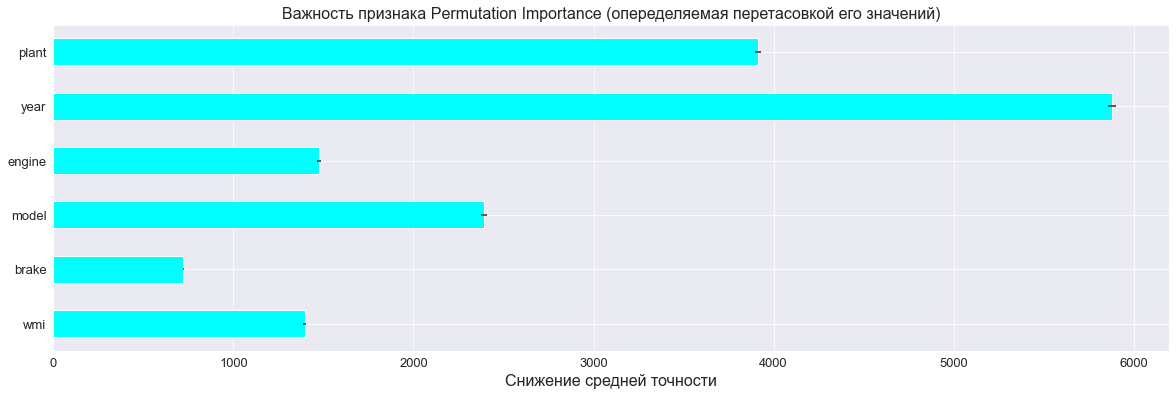

In [26]:
forest_importances.plot.barh(xerr=result.importances_std, figsize=(20, 6), fontsize=13, cmap=plt.cm.cool)
plt.title("Важность признака Permutation Importance (опеределяемая перетасовкой его значений)", fontsize=16)
plt.xlabel("Снижение средней точности", fontsize=16);

RandomForestRegressor с лучшими параметрами: {'rfr__n_estimators': 50, 'rfr__min_samples_split': 4, 'rfr__min_samples_leaf': 4, 'rfr__max_depth': 14, 'rfr__bootstrap': True}
достигла метрики RMSE = __2800.35__. MSE и MAPE составили 15143990.64 и 0.31 соответственно.  
Наиболее значимыми признаками для модели RandomForestRegressor являются `год выпуска`, `завод изготовления` и `модель автомобиля`

### LGBMRegressor

In [27]:
# Преобразуем тип данных object в category, используемый LightGBM 

cat_features = [features_train, features_test]

for elem in cat_features:
    for col in elem.columns:
        col_type = elem[col].dtype
        if col_type == 'object':
            elem[col] = elem[col].astype('category')

In [28]:
print(cat_features[0].info())
cat_features[1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53913 entries, 51570 to 2177
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   wmi     53913 non-null  category
 1   brake   53913 non-null  category
 2   model   53913 non-null  category
 3   engine  53913 non-null  category
 4   year    53913 non-null  category
 5   plant   53913 non-null  category
dtypes: category(6)
memory usage: 805.3 KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17971 entries, 63581 to 25330
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   wmi     17971 non-null  category
 1   brake   17971 non-null  category
 2   model   17971 non-null  category
 3   engine  17971 non-null  category
 4   year    17971 non-null  category
 5   plant   17971 non-null  category
dtypes: category(6)
memory usage: 278.0 KB


#### Обучение

In [29]:
model_lgbm = lgb.LGBMRegressor(random_state=RANDOM_STATE)

param_random_lgbm = {
    'n_estimators': range(50, 251, 50),
    'max_depth': range(10, 100, 10),
    'num_leaves': range(2, 250, 10),
    'learning_rate': (0.1, 0.2, 0.3)
}

rs_lgbm = RandomizedSearchCV(
    model_lgbm,
    param_distributions=param_random_lgbm,
    scoring={'RMSE': 'neg_root_mean_squared_error', 'MAPE': 'neg_mean_absolute_percentage_error',
             'MSE': 'neg_mean_squared_error'},
    refit='RMSE',
    cv=4,
    n_jobs=-1,
    n_iter=25,
    random_state=RANDOM_STATE
)

In [30]:
%%time
rs_lgbm.fit(cat_features[0], target_train)
print('Метрика RMSE:', abs(rs_lgbm.best_score_).round(2))
print('Метрика MSE:', abs(rs_lgbm.cv_results_['mean_test_MSE']).mean().round(2))
print('Метрика MAPE:', abs(rs_lgbm.cv_results_['mean_test_MAPE']).mean().round(2))
print('Лучшие параметры:', rs_lgbm.best_params_)

Метрика RMSE: 2767.59
Метрика MSE: 7712875.38
Метрика MAPE: 0.2
Лучшие параметры: {'num_leaves': 32, 'n_estimators': 100, 'max_depth': 90, 'learning_rate': 0.2}
CPU times: total: 2.38 s
Wall time: 52.1 s


#### Анализ важности фичей

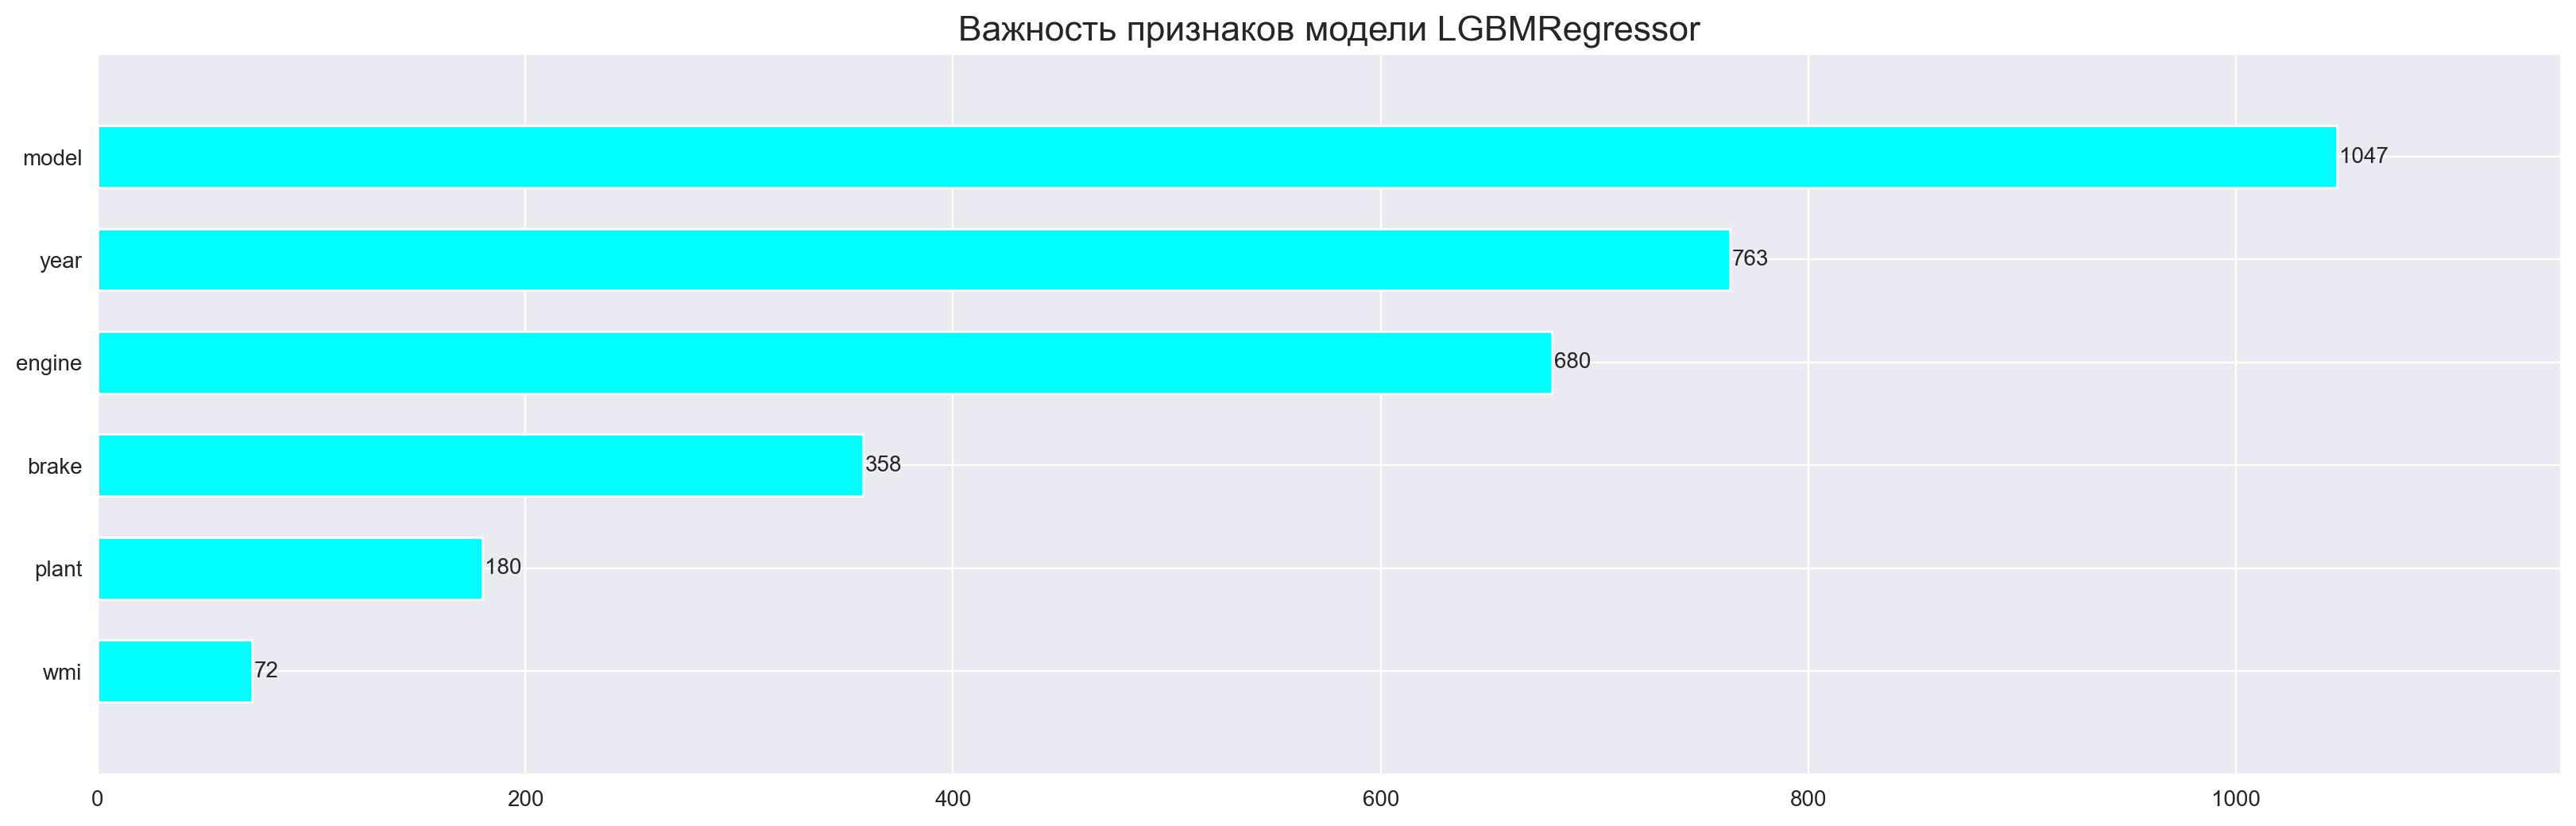

In [31]:
# Получаем обученную модель
best_model_lgbm = rs_lgbm.best_estimator_

# Строим график важности признаков
lgb.plot_importance(best_model_lgbm, height=.6, title='Feature importance', xlabel='',
                         ylabel='', figsize=(20, 6), color='cyan', dpi=200
                         )
plt.title("Важность признаков модели LGBMRegressor", fontsize=16);

LGBMRegressor с лучшими параметрами: {'num_leaves': 32, 'n_estimators': 100, 'max_depth': 90, 'learning_rate': 0.2} немного обошла RandomForestRegressor и достигла метрики RMSE = __2767.59__. По метрикам MSE и MAPE LGBMRegressor показала себя ещё выигрышнее, результаты составили 7712875.38 и 0.2 соответственно.
Наиболее значимыми признаками для LGBMRegressor являются `модель автомобиля`, `год выпуска`, `двигатель`.

### DummyRegressor

In [32]:
cv_dummy = cross_validate(DummyRegressor(), features_train, target_train, scoring=('neg_mean_squared_error',
                                                                                   'neg_root_mean_squared_error',
                                                                                   'neg_mean_absolute_percentage_error'))

print('Метрика MSE константной модели:', abs(cv_dummy['test_neg_mean_squared_error']).mean().round(2))
print('Метрика RMSE константной модели:', abs(cv_dummy['test_neg_root_mean_squared_error']).mean().round(2))
print('Метрика MAPE константной модели:', abs(cv_dummy['test_neg_mean_absolute_percentage_error']).mean().round(2))

Метрика MSE константной модели: 61522678.55
Метрика RMSE константной модели: 7843.55
Метрика MAPE константной модели: 1.03


По всем параметрам DummyRegressor сильно уступает RandomForestRegressor и LGBMRegressor. Обе наши модели подтвердили адекватность

## Проверка лучшей модели на тесте

In [33]:
%%time
predicted_test = rs_lgbm.predict(cat_features[1])

CPU times: total: 125 ms
Wall time: 92.9 ms


In [34]:
metric_test_rmse = mean_squared_error(target_test, predicted_test, squared=False)
metric_test_mse = mean_squared_error(target_test, predicted_test)
metric_test_mape = mean_absolute_percentage_error(target_test, predicted_test)
print(f'Метрика RMSE на тестовой выборке: {metric_test_rmse:.2f}')
print(f'Метрика MSE на тестовой выборке: {metric_test_mse:.2f}')
print(f'Метрика MAPE на тестовой выборке: {metric_test_mape:.2f}')

Метрика RMSE на тестовой выборке: 2756.46
Метрика MSE на тестовой выборке: 7598078.62
Метрика MAPE на тестовой выборке: 0.20


## Вывод

Нам были предоставлены данные по автомобилям Ford, произведённым в Северной Америке, содержащие информацию о их VIN-кодах и стоимости. С помощью регулярных выражений мы распарсили VIN-коды, сформировав из них признаки и составив датасет, а также построили модель, предсказывающую стоимость автомобилей на основании полученных данных.  
На кросс-валидации мы определили метрики 3-х моделей RandomForestRegressor, LGBMRegressor, DummyRegressor с быстрым подбором гиперпараметров RandomizedSearchCV, применением порядкового кодирования категориальных переменных и использованием пайплайна, где это требуется. Провели сравнение с константной моделью, RandomForestRegressor и LGBMRegressor подтвердили адекватность.  
Лучшей моделью стала __LGBMRegressor__ с параметрами: __{'num_leaves': 32, 'n_estimators': 100, 'max_depth': 90, 'learning_rate': 0.2}__  
и результатами метрик:  
- `RMSE` = `2767.59`,  
- `MSE` = `7712875.38`,  
- `MAPE` = `0.2`.  

Анализ важности признаков определил, что наиболее значимыми для LGBMRegressor фичами являются: `модель автомобиля`, `год выпуска`, `двигатель`.